In [1]:
import mesa

from epstein_network_civil_violence.agent import Inhabitant, Police
from epstein_network_civil_violence.model import EpsteinNetworkCivilViolence
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.colors import ListedColormap

we mainly focus on two things here: legitimacy_impact and time
legitimacy_impact is how fast would the mean field change work, you can see the mean_field_spread function in agent.py:
    self.regime_legitimacy += self.legitimacy_impact * (mean_legitimacy - self.regime_legitimacy)

And I might make some agents' legitimacy never change to create some patterns.

different legitimacy impacts to compare in different time steps:

for a certain legitimacy impact, find how it change via time:

In [4]:
# Function to create a custom colormap
def create_colormap():
    """
    Create a colormap with 0 as white and the rest as 'viridis'.
    Returns:
        ListedColormap: Custom colormap
    """
    cmap = plt.cm.viridis
    # Make 0 into white
    colors = cmap(np.arange(cmap.N))
    colors[0, :] = np.array([1, 1, 1, 1])
    new_cmap = ListedColormap(colors)
    return new_cmap

# Function to create a model instance with specific parameters
def create_model(legitimacy_impact=0.1, legitimacy_type="heterogeneous", legitimacy_matrix = None, legitimacy=0.8, legitimacy_width=0.1, citizen_density=0.9):
    """
    Create an instance of EpsteinNetworkCivilViolence model with specific parameters.
    Args:
        legitimacy_impact (float): The impact of legitimacy to use in the model
        legitimacy_matrix (np.array): Matrix specifying the legitimacy by regions
    Returns:
        model: An instance of the model
    """
    model = EpsteinNetworkCivilViolence(
        width=80,
        height=80,
        citizen_density=0.9,
        cop_density=0.074,
        citizen_vision=7,
        cop_vision=7,
        legitimacy=legitimacy,
        max_jail_term=1000,
        active_threshold=0.1,
        arrest_prob_constant=2.3,
        movement=True,
        max_iters=300,
        alpha=0.1,
        jail_factor=1.1,
        legitimacy_impact=legitimacy_impact,
        legitimacy_type=legitimacy_type,
        legitimacy_matrix=legitimacy_matrix,
        use_mean_field=True,
        legitimacy_width=legitimacy_width,
        cop_density_mode='constant',
        legitimacy_mode='constant'
    )
    return model

# Function to run the model and collect heatmap data at specified time steps
def run_model_and_collect_data_over_time(model, time_steps):
    """
    Run the model and collect heatmap data at specified time steps.
    Args:
        model: An instance of the EpsteinNetworkCivilViolence model
        time_steps (list): List of time steps to capture
    Returns:
        list: Heatmap data for each time step
    """
    heatmaps = []
    for step in range(max(time_steps) + 1):
        model.step()
        if step in time_steps:
            agent_data = model.datacollector.get_agent_vars_dataframe()
            current_data = agent_data.xs(step, level='Step')
            inhabitant_data = current_data[current_data['breed'] == 'citizen']
            # Get x, y and regime_legitimacy
            x = inhabitant_data.x.values
            y = inhabitant_data.y.values
            legitimacy = inhabitant_data.regime_legitimacy.values
            grid_size = (80, 80)
            heatmap_data = np.zeros(grid_size)
            for i in range(len(x)):
                heatmap_data[int(x[i]), int(y[i])] = legitimacy[i]
            heatmaps.append(heatmap_data)
    return heatmaps

# Function to plot heatmaps
def plot_heatmaps(heatmaps, time_steps):
    """
    Plot heatmaps for each time step.
    Args:
        heatmaps (list): Heatmap data for each time step
        time_steps (list): List of time steps to capture
    """
    num_cols = 2
    num_rows = (len(time_steps) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
    axes = axes.flatten()
    cmap = create_colormap()

    for i, ax in enumerate(axes):
        if i < len(time_steps):

            data_with_nan = np.where(heatmaps[i] == 0, np.nan, heatmaps[i])
            min_value = np.nanmin(data_with_nan)

            im = ax.imshow(heatmaps[i], cmap=cmap, interpolation='nearest', vmin=min_value-0.01, vmax=np.max(heatmaps[i]))
            ax.set_title(f'Time step {time_steps[i]}')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
        else:
            fig.delaxes(ax)  # Remove empty subplot

    # Adjust the layout to make space for the colorbar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax, label='Regime Legitimacy')

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# # Function to extract data from the model
# def extract_data(model):
#     """
#     Extract agent data from the model's data collector.
#     Args:
#         model: An instance of the EpsteinNetworkCivilViolence model
#     Returns:
#         DataFrame: Agent data collected by the model
#     """
#     return model.datacollector.get_agent_vars_dataframe()

# Function to plot legitimacy distribution histograms at specified time steps

def plot_legitimacy_one_histogram(agent_data, time_step = 0):
    # Filter the data for the specified time step
    step_data = agent_data[agent_data.index.get_level_values('Step') == time_step]
    legitimacy_values = step_data['regime_legitimacy']

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(legitimacy_values, edgecolor='black', bins=20)
    plt.title(f'Legitimacy Distribution at Time Step {time_step}')
    plt.xlabel('Legitimacy')
    plt.ylabel('Number of Citizens')

    # Display the plot
    plt.tight_layout()
    plt.show()

def plot_legitimacy_histograms(agent_data, time_steps):
    """
    Plot legitimacy distribution histograms at specified time steps.
    Args:
        agent_data (DataFrame): Agent data collected by the model
        time_steps (list): List of time steps to plot histograms for
    """
    num_steps = len(time_steps)
    num_rows = (num_steps + 1) // 2  # Calculate the number of rows needed

    fig, axs = plt.subplots(num_rows, 2, figsize=(15, 3 * num_rows))
    axs = axs.flatten()  # Flatten the array for easy indexing

    for i, step in enumerate(time_steps):
        step_data = agent_data.xs(step, level="Step")
        legitimacy_values = step_data['regime_legitimacy']

        # Plot histogram
        axs[i].hist(legitimacy_values, edgecolor='black', bins=20)
        axs[i].set_title(f'Legitimacy Distribution at Time Step {step}')
        axs[i].set_xlabel('Legitimacy')
        axs[i].set_ylabel('Number of Citizens')

    # Remove any empty subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

In [11]:
# Heterogeneous
legitimacy_impact = 0.02
legitimacy_type = "heterogeneous"
time_steps = [0, 10, 30, 100]
heter_model = create_model(legitimacy_impact = legitimacy_impact, legitimacy_type = legitimacy_type, legitimacy=0.5, legitimacy_width=0.3)
heter_heatmaps = run_model_and_collect_data_over_time(heter_model, time_steps)

C:\Users\liaojw\AppData\Local\Temp\ipykernel_150104\517445320.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


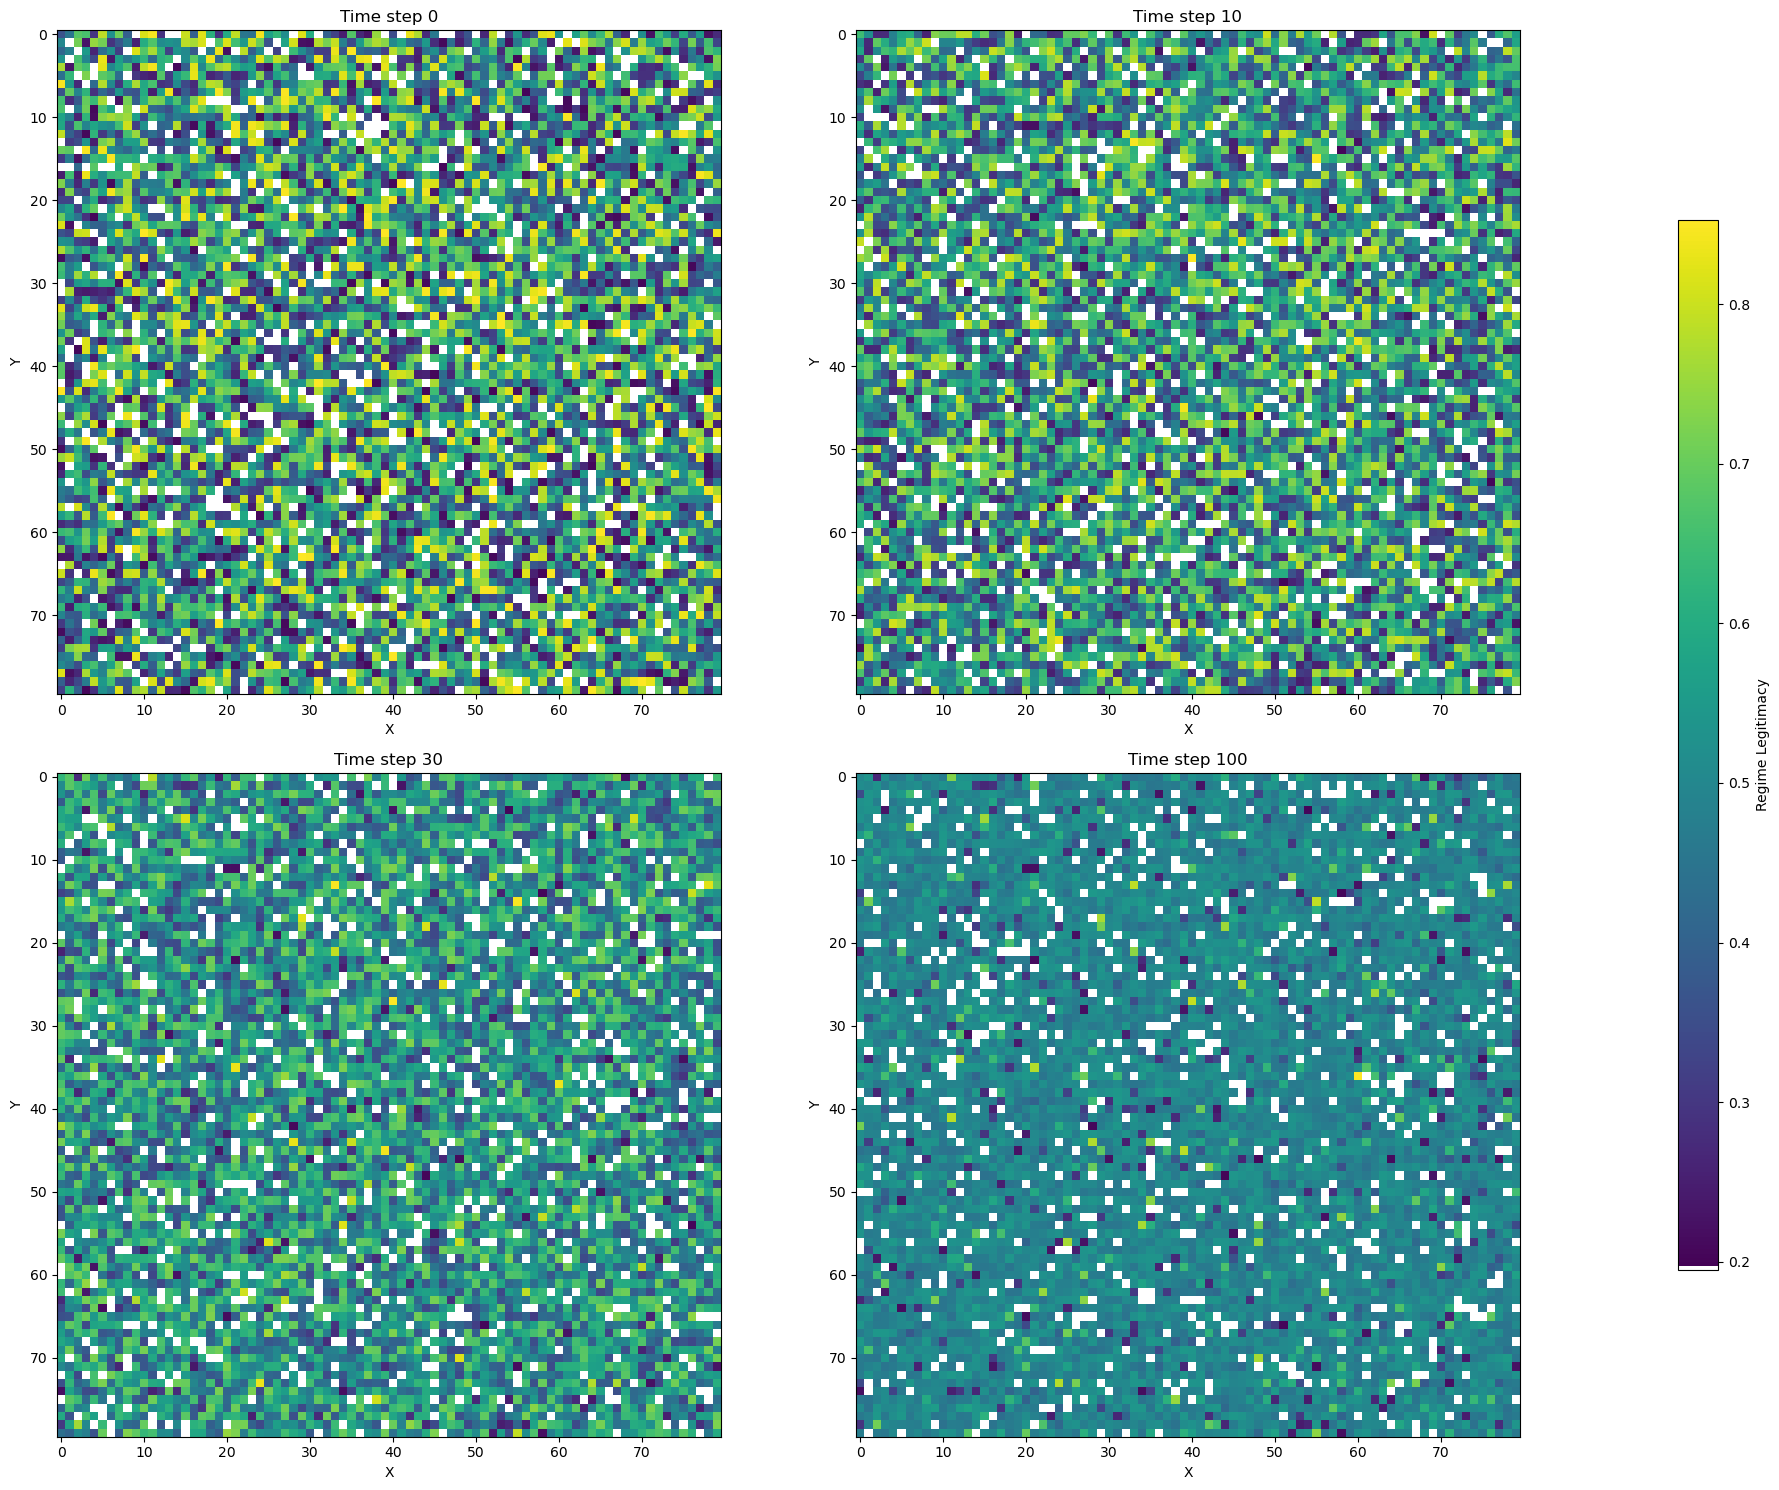

In [12]:
# heatmaps
time_steps = [0, 10, 30, 100]
plot_heatmaps(heter_heatmaps, time_steps)
heter_data = heter_model.datacollector.get_agent_vars_dataframe()

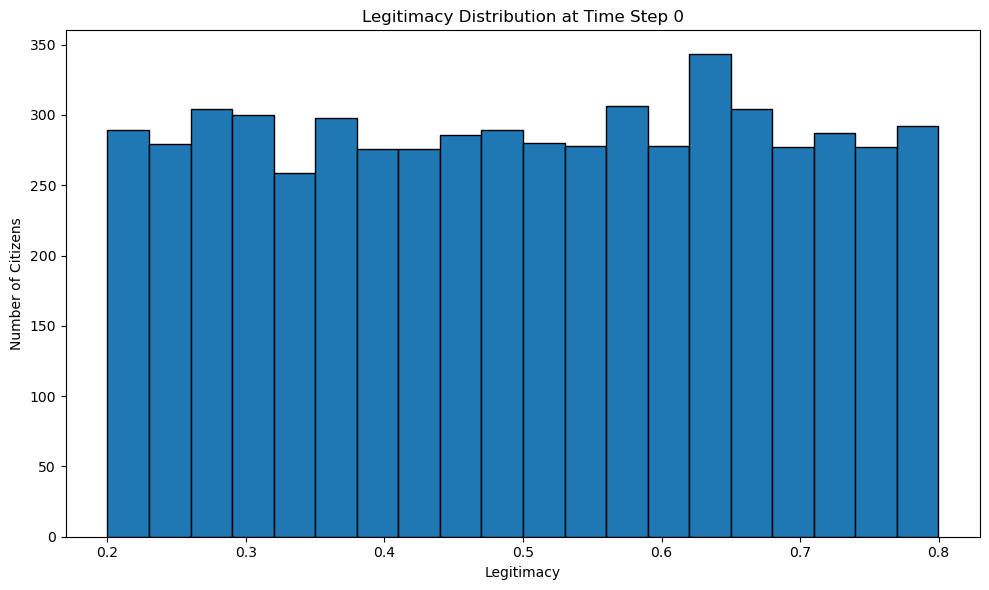

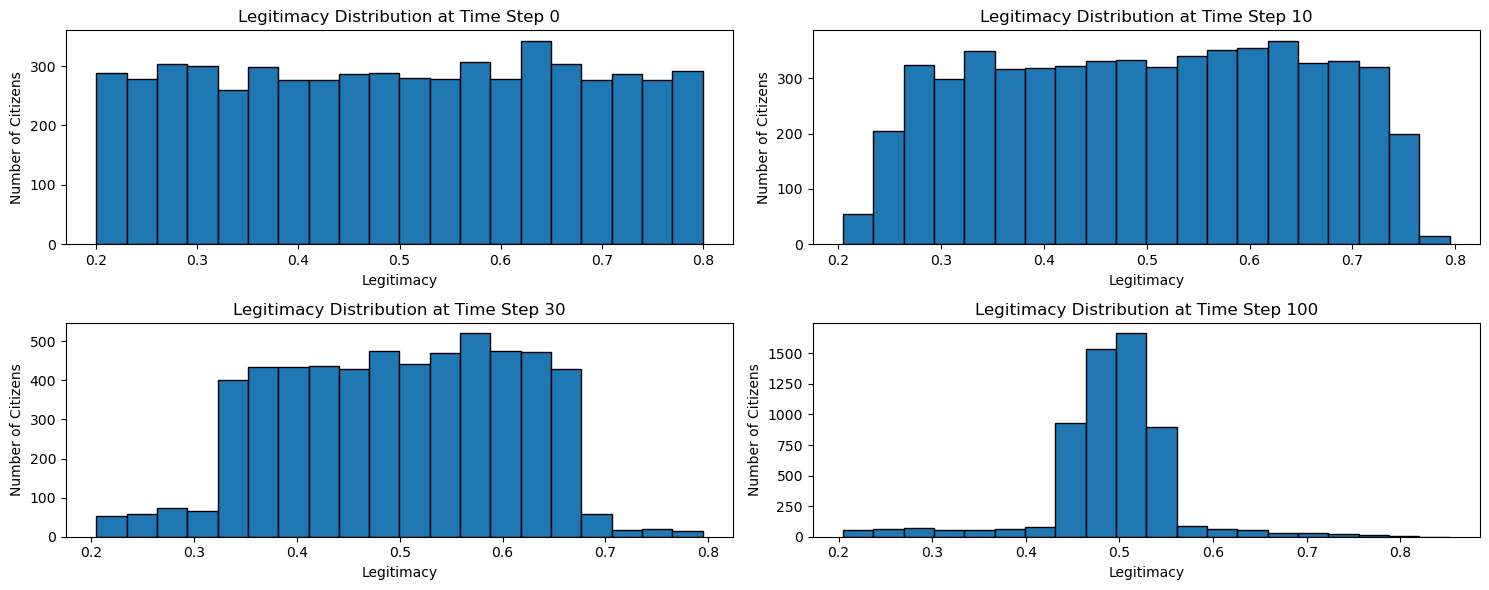

In [13]:
# Plot histograms
plot_legitimacy_one_histogram(heter_data, 0)
plot_legitimacy_histograms(heter_data, [0, 10, 30, 100])

Regional Heterogeneous Legitimacy:

In [27]:
# Regions
legitimacy_impact = 0.02
legitimacy_type = "by_regions"
legitimacy_matrix = np.array([
    [0.8, 0.6, 0.4],
    [0.6, 0.4, 0.2]
])
time_steps = [0, 10, 30, 100]
regions_model = create_model(legitimacy_impact, legitimacy_type, legitimacy_matrix)
regions_heatmaps = run_model_and_collect_data_over_time(regions_model, time_steps)

C:\Users\liaojw\AppData\Local\Temp\ipykernel_150104\517445320.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


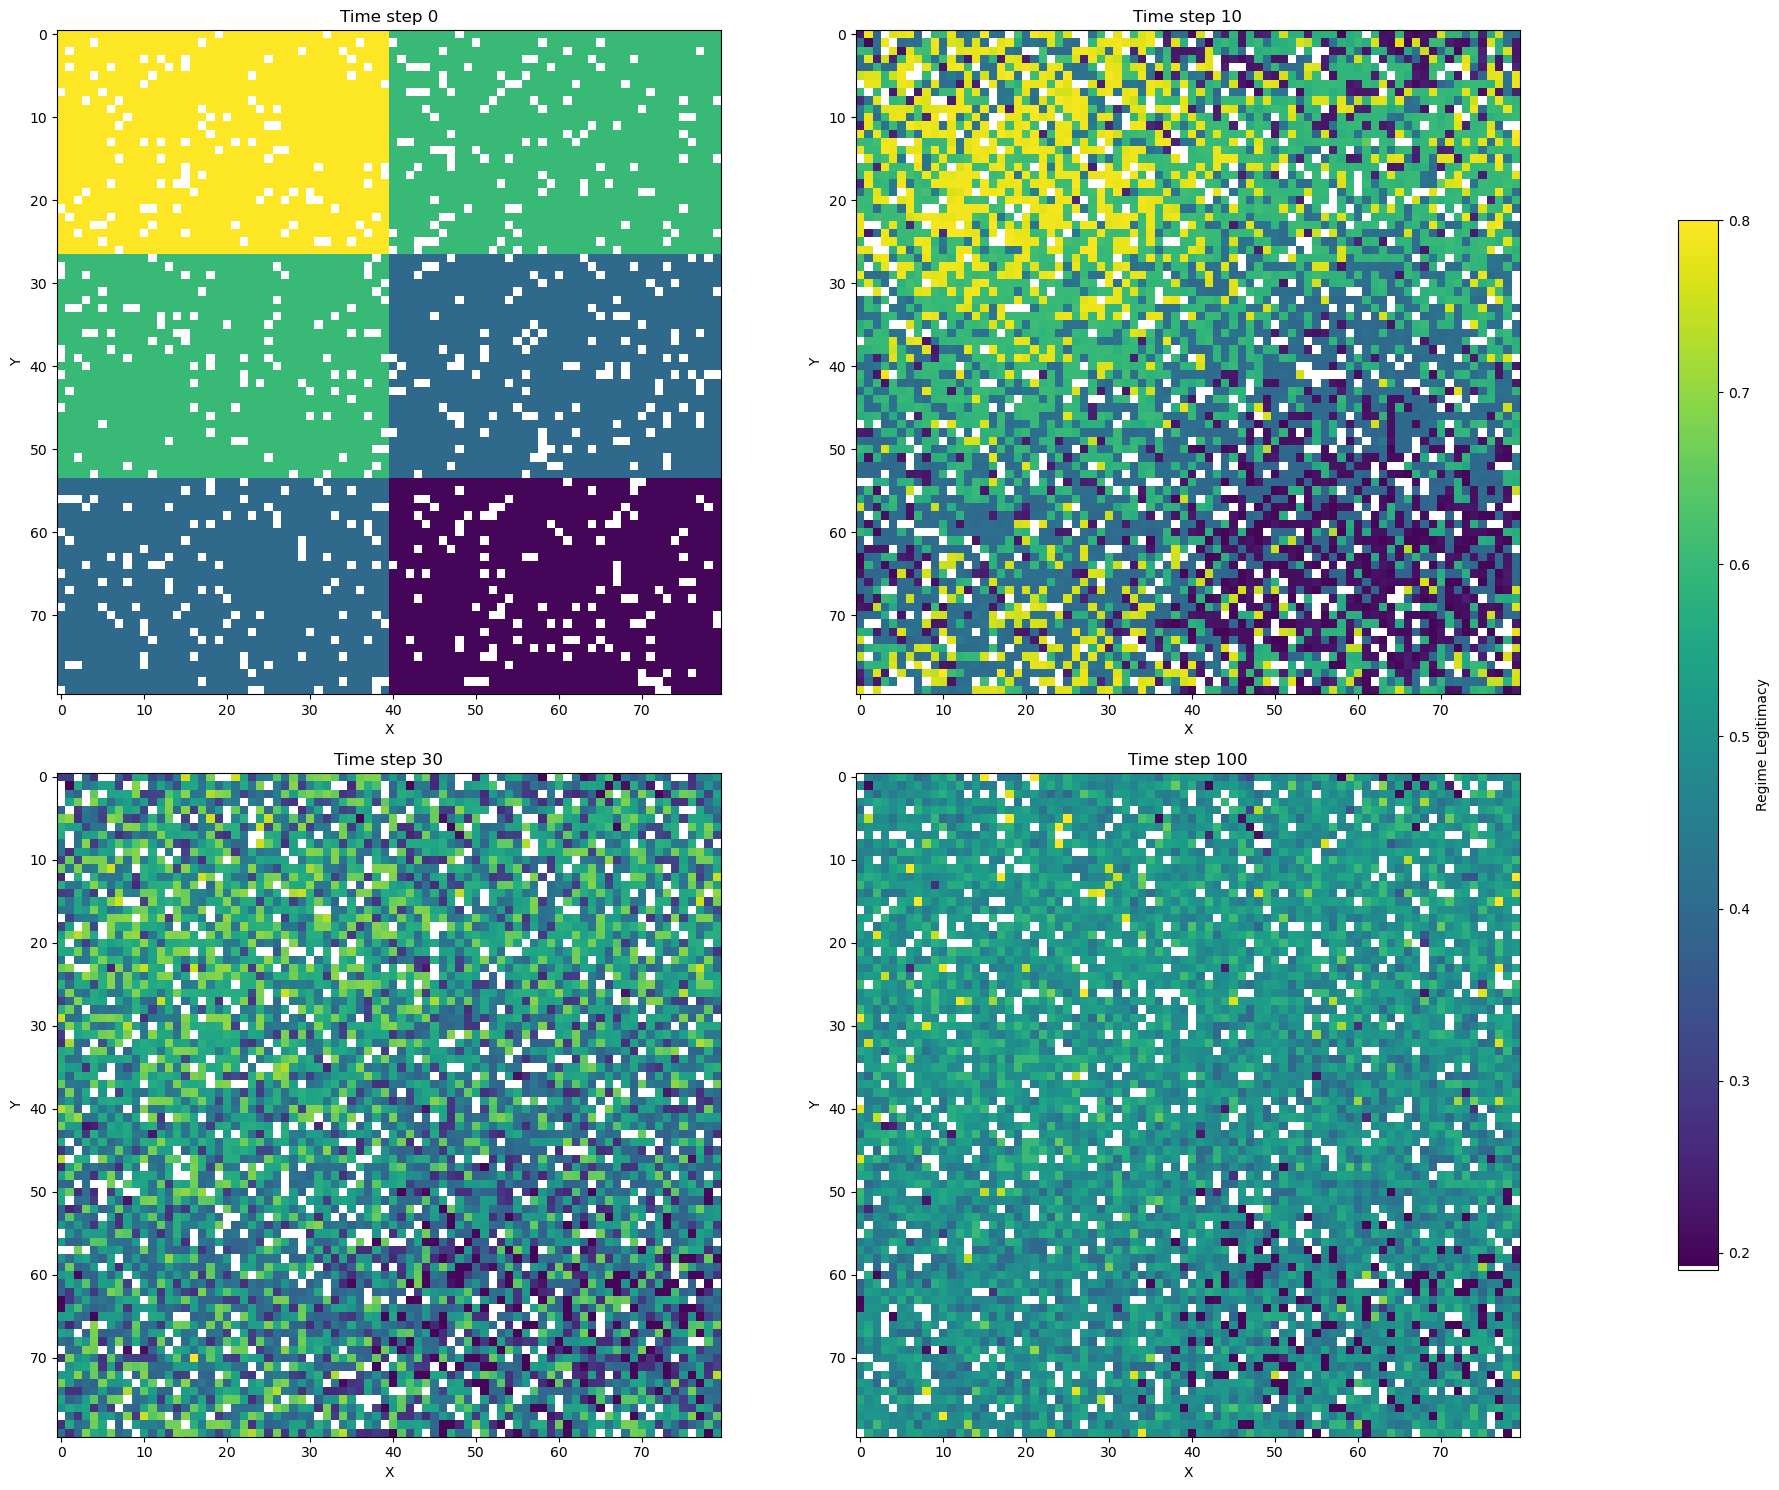

In [28]:
plot_heatmaps(regions_heatmaps, time_steps)
regions_data = regions_model.datacollector.get_agent_vars_dataframe()

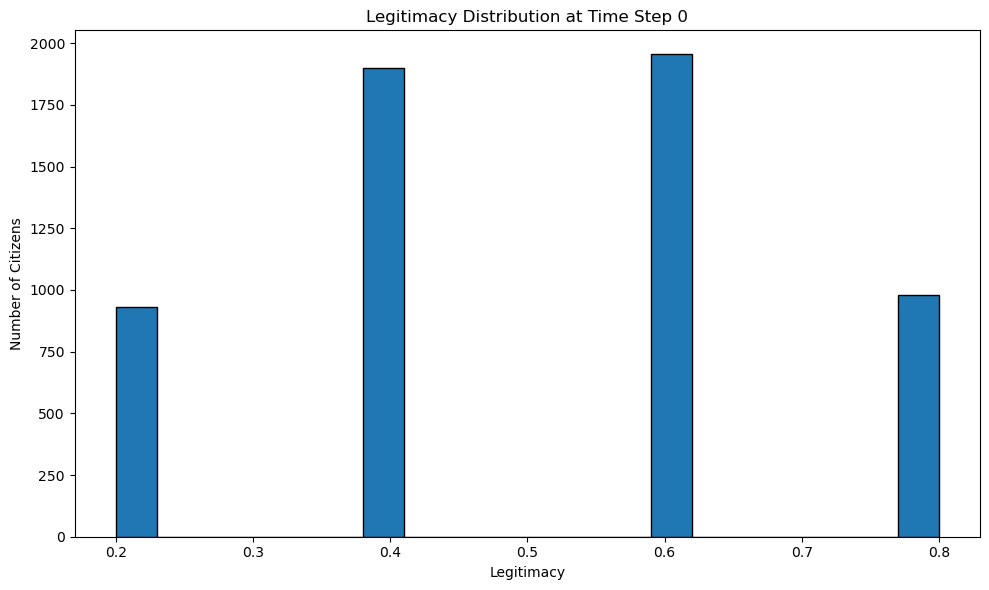

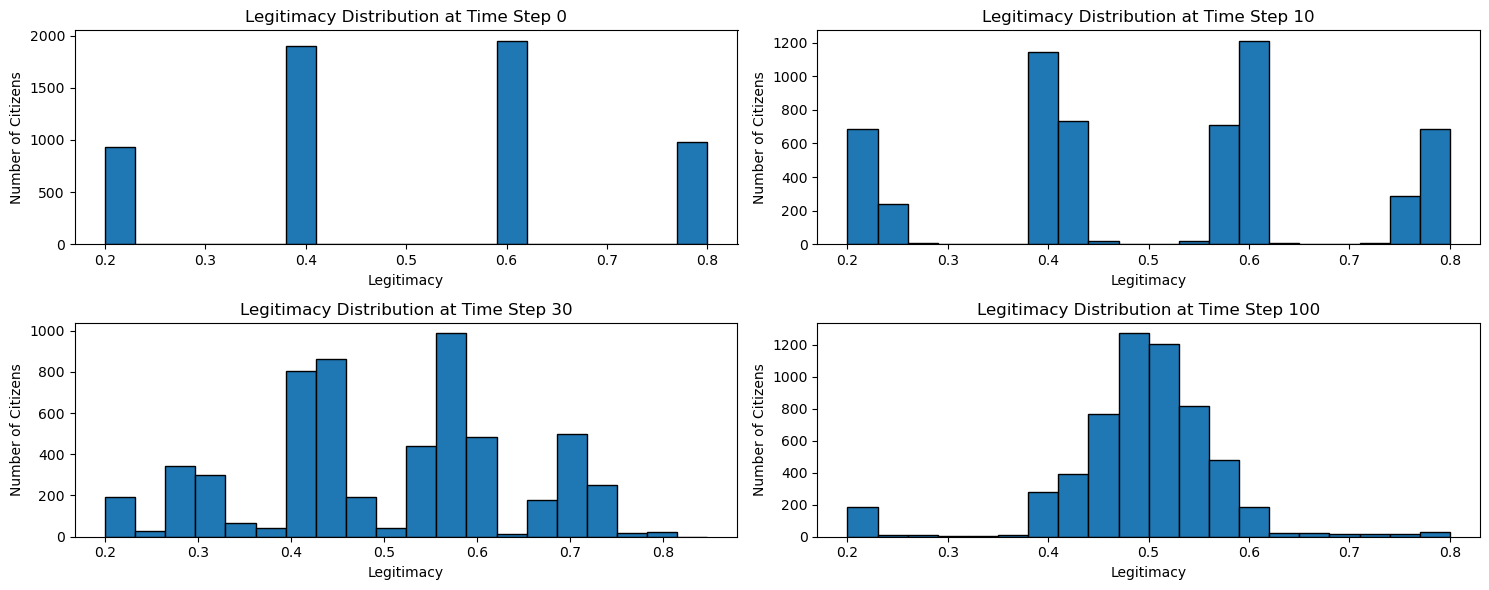

In [29]:
# Plot histograms
plot_legitimacy_one_histogram(regions_data, 0)
plot_legitimacy_histograms(regions_data, [0, 10, 30, 100])

## For Initialization

In [44]:
# Function to plot heatmaps
def plot_heatmaps_init(heatmaps, time_steps, legitimacy_type):
    """
    Plot heatmaps for each time step.
    Args:
        heatmaps (list): Heatmap data for each time step
        time_steps (list): List of time steps to capture
    """
    num_cols = 4
    num_rows = (len(time_steps) + num_cols - 1) // num_cols
    # fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
    # axes = axes.flatten()
    cmap = create_colormap()


    plt.figure(figsize=(10, 7))
    cmap = create_colormap()

    data_with_nan = np.where(heatmaps[0] == 0, np.nan, heatmaps[0])
    min_value = np.nanmin(data_with_nan)

    plt.figure(figsize=(10, 7))
    im = plt.imshow(heatmaps[0], cmap=cmap, interpolation='nearest', vmin=min_value-0.01, vmax=np.max(heatmaps[0]))
    plt.title(f'Time step 0 for {legitimacy_type} model')
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.tight_layout()
    plt.show()

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

<Figure size 1000x700 with 0 Axes>

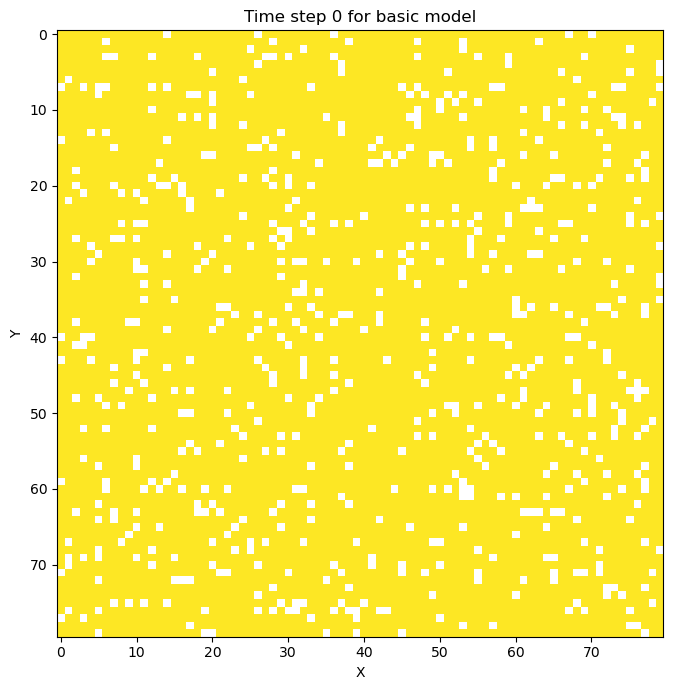

<Figure size 640x480 with 0 Axes>

In [45]:
if __name__ == "__main__":
    legitimacy_type = "basic"
    time_steps = [0]
    citizen_density=0.7
    model = create_model(legitimacy_type = legitimacy_type)
    heatmaps = run_model_and_collect_data_over_time(model, time_steps)
    plot_heatmaps_init(heatmaps, time_steps, legitimacy_type)

<Figure size 1000x700 with 0 Axes>

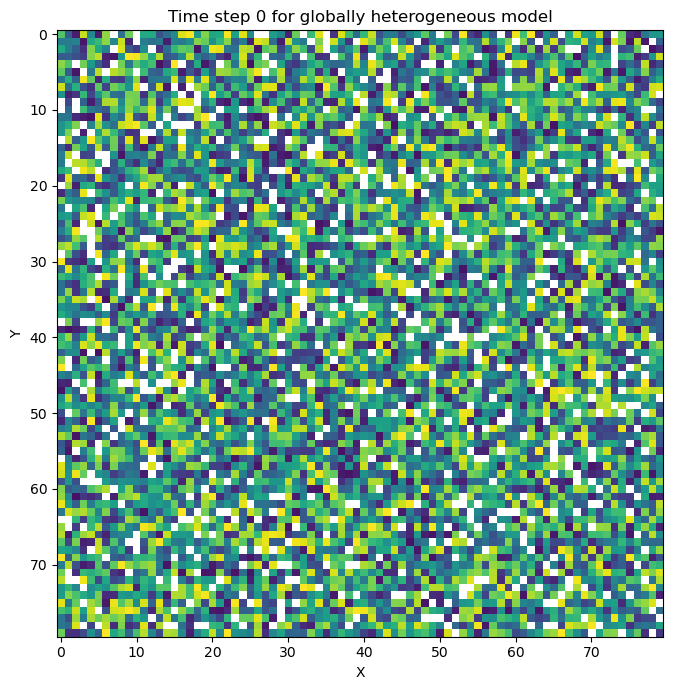

<Figure size 640x480 with 0 Axes>

In [46]:
if __name__ == "__main__":
    legitimacy_type = "globally heterogeneous"
    time_steps = [0]
    citizen_density=0.7
    model = create_model(legitimacy_type = "heterogeneous")
    heatmaps = run_model_and_collect_data_over_time(model, time_steps)
    plot_heatmaps_init(heatmaps, time_steps, legitimacy_type)

<Figure size 1000x700 with 0 Axes>

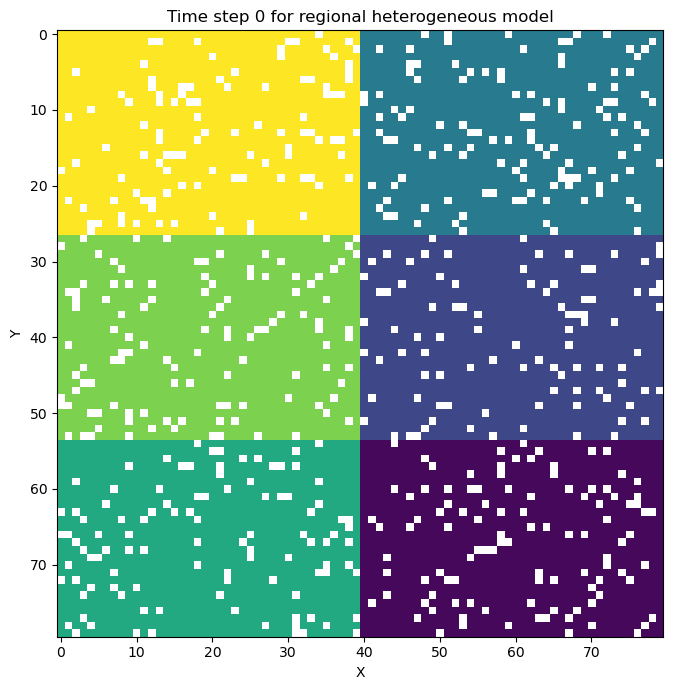

<Figure size 640x480 with 0 Axes>

In [47]:
if __name__ == "__main__":
    legitimacy_type = "regional heterogeneous"
    legitimacy_matrix = np.array([
        [0.8, 0.7, 0.6],
        [0.5, 0.4, 0.3]
    ])
    time_steps = [0]
    model = create_model(legitimacy_impact, "by_regions", legitimacy_matrix)
    heatmaps = run_model_and_collect_data_over_time(model, time_steps)
    plot_heatmaps_init(heatmaps, time_steps, legitimacy_type)